In [1]:
!jupyter nbconvert --to python seqInit.ipynb

[NbConvertApp] Converting notebook seqInit.ipynb to python
[NbConvertApp] Writing 1367 bytes to seqInit.py


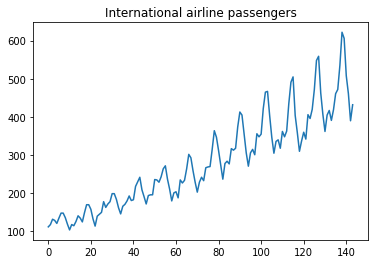

dataSet shape :	 (144, 1)
train data shape : (120, 1)
real data shape : (144, 1)


In [2]:
# 引入torch相关模块
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import init

# 引入初始化文件中的相关内容
from seqInit import toTs, cudAvl
from seqInit import input_size
from seqInit import train, real

# 引入画图工具
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# 定义GRU模型

class gruModel(nn.Module) :
    def __init__(self, in_dim, hidden_dim, out_dim, hidden_layer) :
        super().__init__()
        self.gruLayer = nn.GRU(in_dim, hidden_dim, hidden_layer)
        self.fcLayer = nn.Linear(hidden_dim, out_dim)
    
    def forward(self, x) :
        out, _ = self.gruLayer(x)
        out = out[12:]
        out = self.fcLayer(out)
        return out
        
# 输入维度为1，输出维度为1，隐藏层维数为5, 定义LSTM层数为2
gru = cudAvl(gruModel(1, 5, 1, 2))

# 定义损失函数和优化函数

criterion = nn.MSELoss()
optimizer = optim.Adam(gru.parameters(), lr = 1e-2)

In [4]:
# 处理输入

train = train.reshape(-1, 1, 1)
x = torch.from_numpy(train[:-1])
y = torch.from_numpy(train[1:])[12:]
print(x.shape, y.shape)

torch.Size([119, 1, 1]) torch.Size([107, 1, 1])


Epoch[400/4000], Loss: 0.00212
Epoch[800/4000], Loss: 0.00084
Epoch[1200/4000], Loss: 0.00067
Epoch[1600/4000], Loss: 0.00057
Epoch[2000/4000], Loss: 0.00048
Epoch[2400/4000], Loss: 0.00034
Epoch[2800/4000], Loss: 0.00025
Epoch[3200/4000], Loss: 0.00019
Epoch[3600/4000], Loss: 0.00017
Epoch[4000/4000], Loss: 0.00016


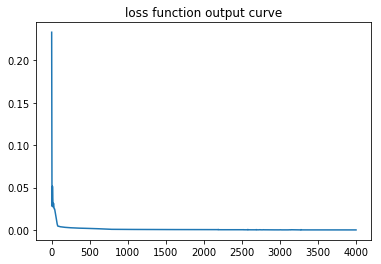

CPU times: user 1min 1s, sys: 11.1 s, total: 1min 13s
Wall time: 1min 13s


In [5]:
%%time
# 训练模型

frq, sec = 4000, 400
loss_set = []

for e in range(1, frq + 1) :
    inputs = cudAvl(Variable(x))
    target = cudAvl(Variable(y))
    #forward
    output = gru(inputs)
    loss = criterion(output, target)
    # update paramters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    #print training information
    print_loss = loss.data[0]
    loss_set.append((e, print_loss))
    if e % sec == 0 :
        print('Epoch[{}/{}], Loss: {:.5f}'.format(e, frq, print_loss))

# 作出损失函数变化图像
pltX = np.array([loss[0] for loss in loss_set])
pltY = np.array([loss[1] for loss in loss_set])
plt.title('loss function output curve')
plt.plot(pltX, pltY)
plt.show()

torch.Size([143, 1, 1]) (131,) (143,)


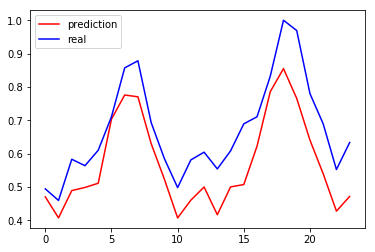

In [6]:
gru = gru.eval()

# 预测结果并比较

px = real[:-1].reshape(-1, 1, 1)
px = torch.from_numpy(px)
ry = real[1:].reshape(-1)
varX = cudAvl(Variable(px, volatile=True))
py = gru(varX).data
py = np.array(py).reshape(-1)
print(px.shape, py.shape, ry.shape)

# 画出实际结果和预测的结果
plt.plot(py[-24:], 'r', label='prediction')
plt.plot(ry[-24:], 'b', label='real')
plt.legend(loc='best')
